# **Face Detection Using Dlib & OpenCV**

## 🧠 What is Dlib?

- **Dlib** is a modern C++ toolkit with Python bindings.
- It is used for **image processing** and **computer vision** tasks such as:
  - Face detection
  - Facial landmark detection
  - Object tracking
  - Machine learning algorithms

---

## 🛠️ Installation of Dlib for Linux and Windows

### 🔷 On Windows
> Run the following commands in **Command Prompt (CMD)**:

```bash
pip install cmake
pip install dlib
```

### 🔷 On Linux (Ubuntu/Debian)
> Run the following commands on terminal:
```bash
sudo apt-get install cmake
sudo apt-get install build-essential
sudo apt-get install python3-dev
pip install dlib
```

In [19]:
# import required libraries
import os
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Specify the path for pre-trained opencv face detection and dlib landmark detection models
# These models should be downloaded and placed in the specified paths
LANDMARK_MODEL_PATH  = "../models/shape_predictor_68_face_landmarks.dat"
FACE_DETECTOR_MODEL_PATH = '../models/res10_300x300_ssd_iter_140000.caffemodel'
MODEL_DEFINITION_PATH = "../models/deploy.prototxt"

## 🔍 Models Used in Face Detection Pipeline

### 1. `shape_predictor_68_face_landmarks.dat`

- **Type:** Pre-trained facial landmark detector model for Dlib.
- **Purpose:**  
  Detects **68 key facial landmarks** such as eyes, nose, mouth, jawline, and eyebrows within a detected face.
- **Details:**  
  - The model takes a grayscale face image and a bounding box as input.
  - Outputs 68 (x, y) coordinates corresponding to specific facial features.
- **File Format:** `.dat` file (Dlib’s serialized model format)
- **Source:**  
  Available from the [Dlib model zoo](http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2)
- **Use Case:**  
  Helpful for precise face alignment, facial expression analysis, gaze tracking, and face-based applications.

---

### 2. `res10_300x300_ssd_iter_140000.caffemodel`

- **Type:** Pre-trained face detection model based on the **Single Shot Multibox Detector (SSD)** architecture.
- **Purpose:**  
  Detects face bounding boxes in images efficiently and accurately.
- **Details:**  
  - Model trained on a large face dataset using Caffe framework.
  - Uses ResNet-10 as the backbone. For feature extraction and generating feature maps.
  - SSD head uses those feature maps to predict classes and bounding box location with confidence score.
  - Designed for real-time face detection.
- **Associated File:**  
  `deploy.prototxt` — defines the network architecture for inference.
- **File Format:** `.caffemodel` (binary weights file for Caffe)
- **Source:**  
  Often distributed with OpenCV or can be downloaded from official OpenCV GitHub repositories.
- **Use Case:**  
  Provides fast and reliable face detection results, which can be further processed with landmark detectors.

---

### Summary Table

| Model                                  | Framework | File Type  | Function                    |
|---------------------------------------|-----------|------------|-----------------------------|
| `shape_predictor_68_face_landmarks.dat` | Dlib      | `.dat`     | Facial landmark detection    |
| `res10_300x300_ssd_iter_140000.caffemodel` | Caffe     | `.caffemodel` | Face detection (bounding boxes) |



In [6]:
# Load the all models from above specified paths
net = cv2.dnn.readNetFromCaffe(MODEL_DEFINITION_PATH, FACE_DETECTOR_MODEL_PATH)
shape_predictor = dlib.shape_predictor(LANDMARK_MODEL_PATH)

### 🧠 Understanding `blob` from OpenCV DNN Face Detection Model

To perform face detection using the OpenCV DNN module, we first convert the input image into a **blob** using:

<sub>

```python
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, 
                             (300, 300), (104.0, 177.0, 123.0))
```

</sub>

#### 🔍 What is a `blob`?
A **blob** is a 4D NumPy array that serves as the standardized input format for DNN models.  
It includes:  
`(batch size, number of channels, height, width)`  
→ In this case: `(1, 3, 300, 300)`.

---

### 📌 Arguments of `cv2.dnn.blobFromImage`

| Argument       | Example                          | Description                                                                 |
|----------------|----------------------------------|-----------------------------------------------------------------------------|
| `image`        | `cv2.resize(image, (300, 300))`  | Resized input image. The model expects input of size 300×300 pixels.       |
| `scalefactor`  | `1.0`                            | Multiplier for scaling pixel values. Often `1.0` if mean subtraction used. |
| `size`         | `(300, 300)`                     | Desired size of output image (width, height).                              |
| `mean`         | `(104.0, 177.0, 123.0)`          | Mean subtraction values for BGR channels used for normalization.           |
| `swapRB`       | `False` (default)                | Swap R and B channels (used when image is in RGB).                         |
| `crop`         | `False` (default)                | Crop image after resize (usually `False`).                                 |

---

🧠 **Note**: The mean values `(104.0, 177.0, 123.0)` are specific to the Caffe model `res10_300x300_ssd_iter_140000.caffemodel`, and help normalize the image based on the model's training data.

---


In [21]:
# Funtion definition to detect face bounding boxes and landmarks
def DetectFaces(image):
    '''
    Args:
        image: ndarray, input_image read from cv2.imread.
    '''

    (h, w) = image.shape[:2]
    results = []
    # Create a blob from the image and perform face detection
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()  # check markdown for more details about the output of net.forward() output.

    for i in range(0, detections.shape[2]):
        # Extract the confidence associated with the prediction
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Dlib rectangle object for detected faces(check markdown about dlib.rect for more details)
            dlib_rect = dlib.rectangle(startX, startY, endX, endY)

            # Convert image to grayscale for dlib as it requires grayscale images
            gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Detect landmarks using dlib
            landmarks = shape_predictor(gray_img, dlib_rect)  # check markdown for more details about dlib.shape_predictor

            landmarks = np.array([[p.x, p.y] for p in landmarks.parts()])
            x, y, bw, bh = cv2.boundingRect(landmarks)
            

            x -= 25
            y -= 25
            bw += 50
            bh += 50

            x = max(0, x)
            y = max(0, y)
            bw = min(bw, w - x)
            bh = min(bh, h - y)

            results.append(
                {
                    "box": (x, y, bw, bh),
                    "landmarks": landmarks,
                    "confidence": confidence,
                }
            )

    return results

### 📤 Understanding Output of `net.forward()` in OpenCV Face Detection

When you pass the blob through the network like this:

<sub>

```python
net.setInput(blob)
detections = net.forward()
```

</sub>

output - 4D array called `detections`.

---

### 📐 Shape of `detections`

```
detections.shape → (1, 1, N, 7)
```

Where:

- `1` → Batch size (only one image is passed)
- `1` → Number of classes (face only)
- `N` → Number of detections (e.g., 200 possible detections) filter detections using confidence score to get actual faces.
- `7` → Each detection has 7 values:

---

### 📊 Meaning of the 7 Values in Each Detection

For each detection `i`:

```
detections[0, 0, i] = [image_id, class_id, confidence, x_min, y_min, x_max, y_max]
```

| Index | Value        | Description                                                  |
|-------|--------------|--------------------------------------------------------------|
| 0     | `image_id`   | Always 0 (only 1 image in batch)                             |
| 1     | `class_id`   | Always 1 (only 1 class: face)                                |
| 2     | `confidence` | Probability that detection is a face (range: 0 to 1)         |
| 3     | `x_min`      | Normalized X coordinate of top-left corner (0–1)             |
| 4     | `y_min`      | Normalized Y coordinate of top-left corner (0–1)             |
| 5     | `x_max`      | Normalized X coordinate of bottom-right corner (0–1)         |
| 6     | `y_max`      | Normalized Y coordinate of bottom-right corner (0–1)         |

To get actual pixel coordinates, multiply with image width and height.


### 🔲 `dlib.rectangle` Class – Why and How We Use It

The `dlib.rectangle` class represents a bounding box and is commonly used for:

- **Passing face regions** to `dlib.shape_predictor` to extract facial landmarks.
- **Storing bounding boxes** of detected faces or objects.

---

### ✅ Why We Need It

The `dlib.shape_predictor` expects a `dlib.rectangle` object as input, not plain coordinates.

---

### 📌 Commonly Used Attributes

Once you have a `dlib.rectangle` object, you can access:

| Attribute / Method     | Description                          |
|------------------------|--------------------------------------|
| `rect.left()`          | X-coordinate of the left side        |
| `rect.top()`           | Y-coordinate of the top              |
| `rect.right()`         | X-coordinate of the right side       |
| `rect.bottom()`        | Y-coordinate of the bottom           |
| `rect.width()`         | Width of the rectangle               |
| `rect.height()`        | Height of the rectangle              |
| `rect.center()`        | Center point as a `point(x, y)`      |

---

🎯 Use `dlib.rectangle` anytime you need to convert (x1, y1, x2, y2) coordinates into a format that Dlib models can use for further processing.


### 🧩 `dlib.shape_predictor` – Facial Landmark Detector

---
### 🔍 What is `dlib.shape_predictor`?

- Pretrained model used to detect **facial landmarks** from detected facial region.
---

### 🎯 Input

- Grayscale image
- Face bounding box - dlib.rectangle object.


### 📤 Output
- A dlib.full_object_detection object
    1. num_parts attribute -> no. of landmarks. here its value is 68.
    2. part(i) attribute -> ith landmark point (x, y) coordinate.

---

### 🏗️ Architecture Overview

- The predictor uses an **ensemble of regression trees** trained to map image features within the face rectangle to landmark positions.
- It runs **cascade regression**: successive stages refine landmark locations.
- The model was trained on a labeled dataset with annotated facial landmarks.

In [30]:
# Function to visualise detected face bounding boxes
def VisualiseFaces(image, detection_result):
    '''
    Args:
        image: ndarray (BGR image)
        detection result: dict, 
                            {
                            "box": (x, y, w, h),
                            "landmarks": np.ndarray of shape (68, 2),
                            "confidence": float
                            }
    '''

    img_out = image.copy()

    if detection_result is None:
        print("No face Detected.")
        plt.imshow(cv2.cvtColor(img_out, cv2.BGR2RGB))
        plt.axis('off')
        plt.title("No face Detected")
        plt.show()
        return 
    
    for face in detection_result:
        (x, y, w, h) = face["box"]
        cv2.rectangle(img_out, (x, y), (x+w, y+h), (0, 255, 0), 2)

    img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)

    plt.imshow(img_out)
    plt.axis('off')
    plt.title("Face Detected")
    plt.show()
        

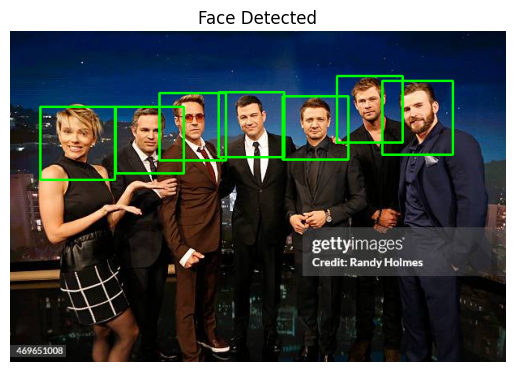

In [ ]:
img = cv2.imread("../test_image.jpg")
result = DetectFaces(img)
VisualiseFaces(img, result)


## ✅ Face Detection and Visualization Completed

- We successfully detected faces using **OpenCV's DNN face detector**.
- Extracted facial landmarks using **Dlib's shape predictor**.
- Cropped and visualized the face region with added padding for better framing.
- This setup is useful for preprocessing before tasks like **emotion recognition**, **face verification**, or **eye tracking**.